# Jax environment

This is the same task as the unity demo but thanks to gpu usage and vectorization this implementation is much faster.

It is usefull to train multiple agents in parallel and for parameter tuning.

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax import serialization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Grid side length
SIDE_L = 9 # even number

class DenseNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(1)(x)
        return x[0]


def move(s, n):
    branches = jnp.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
    s2 = s + branches[n]
    s2 = jnp.clip(s2, 0, SIDE_L)
    return s2

def softmax_action(w, s, values, tau, key):
    policy = nn.softmax(values / tau)
    key, subkey = jax.random.split(key)
    a = jax.random.choice(subkey, jnp.arange(4), p=policy)
    return move(s, a), a, key


def update_w(w, z, x, a0, v, next_v, grad, reward, params):
    # Updates
    z = jax.tree_multimap(
        lambda z, grad: z * params["lambda"] * params["gamma"] + grad, z, grad,
    )
    w = jax.tree_multimap(
        lambda w, z: w + params["alpha"] * z * (reward + params["gamma"] * next_v - v),
        w,
        z,
    )
    return w, z


def poly_input(state, end):
    state = (state - SIDE_L / 2) / (SIDE_L / 2)
    end = (end - SIDE_L / 2) / (SIDE_L / 2)
    return jnp.concatenate(
        [state, end, jnp.square(state), jnp.square(end), state * end]
    )


def step(args):
    w, z, s, end, key, i, params = args

    # Current value
    x = poly_input(s, end)
    value, grad = jax.value_and_grad(DenseNet().apply)(w, x)
    ## Next possible values
    branches = jnp.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
    #                      Left    Right     Up      Down
    s2 = s + branches
    s2 = jnp.clip(s2, 0, SIDE_L)

    next_x = jax.vmap(jax.partial(poly_input, end=end))(s2)
    get_values = jax.partial(DenseNet().apply, w)
    next_values = jax.vmap(get_values)(next_x)
    expected = jnp.dot(next_values, nn.softmax(next_values/params["tau"]))

    s2, a, key = softmax_action(w, s, next_values, params["tau"], key)
    reward = jax.lax.cond(jnp.all(s2 == end), lambda _: 1.0, lambda _: -0.01, None)
    w, z = update_w(w, z, x, a, value, expected, grad, reward, params)
    s = s2
    i += 1
    return w, z, s, end, key, i, params


def episode(episode_n, args):
    s, w, hist, key, params = args
    # define tau as a function of episode
    params["tau"] = 1 / (1 + episode_n / 3.0)
    params["alpha"] *= 0.99
    z = jax.tree_multimap(lambda w: w * 0.0, w)
    key, subkey = jax.random.split(key)
    end = jax.random.randint(subkey, (2,), 0, SIDE_L + 1)
    i = 0

    def cond(a):
        _, _, s, end, _, i, _ = a
        return jnp.any(s != end) * (i < 1000)

    w, z, s, end, key, i, params = jax.lax.while_loop(
        cond, step, (w, z, s, end, key, i, params)
    )
    hist = hist.at[episode_n].set(i)
    return s, w, hist, key, params


@jax.jit
def train(seed, hist, params):
    key = jax.random.PRNGKey(seed)
    net = DenseNet()

    key, subkey = jax.random.split(key)
    w = net.init(subkey, jnp.zeros((10,)))
    s = jnp.array([SIDE_L / 2, SIDE_L / 2])
    s, w, hist, key, params = jax.lax.fori_loop(
        0, episodes, episode, (s, w, hist, key, params)
    )
    return hist, w


@jax.jit
def multi_train(seeds, hist, params):
    hist, _ = jax.vmap(jax.partial(train, hist=hist, params=params))(seeds)
    return jnp.mean(hist, axis=0)


@jax.jit
def parameter_search(seeds, hist, params):
    return jax.vmap(jax.partial(multi_train, seeds, hist))(params)


def plot_grid(end, w):
    a = jnp.arange(0, SIDE_L + 1)
    x, y = jnp.meshgrid(a, a)
    s = jnp.concatenate([x.reshape((-1, 1)), y.reshape((-1, 1))], axis=1)
    xs = jax.vmap(jax.partial(poly_input, end=end))(s)
    get_values = jax.partial(DenseNet().apply, w)
    values = jax.jit(jax.vmap(get_values))(xs)
    sns.heatmap(values.reshape((SIDE_L + 1, SIDE_L + 1)), square=True).invert_yaxis()
    plt.show()

def save(name, w):
    bw = serialization.to_bytes(w)
    with open(name,"wb") as out:
        out.write(bw)

## Single run

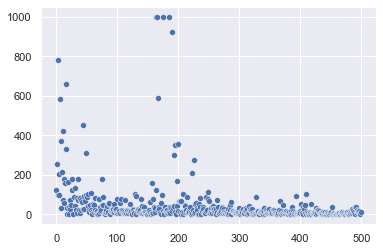

In [5]:
params = {"alpha": 0.01, "lambda": 0.9, "gamma": 0.8, "tau": 1.0}
episodes = 500
hist = jnp.zeros((episodes,))
hist, w = train(1, hist, params)
sns.scatterplot(data=hist)
plt.show()

## Multi runs
Make k runs of n episodes to average performance

32.93234


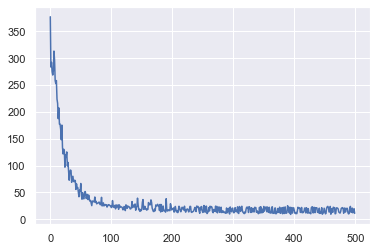

In [3]:
params = {"alpha": 0.01, "lambda": 0.9, "gamma": 0.8, "tau": 1.0}
parallel_runs = 100
episodes = 500
hist = jnp.zeros((episodes,))
seeds = jnp.arange(parallel_runs)
hist = multi_train(seeds, hist, params)
print(jnp.mean(hist))
sns.lineplot(data=hist)
plt.show()

## Comparing parameters
Compare different parameters by averaging performance 

[32.93234  33.861423]


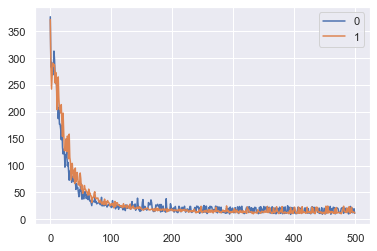

In [4]:
parallel_runs = 100
episodes = 500
hist = jnp.zeros((episodes,))
seeds = jnp.arange(parallel_runs)
params = {
    "alpha": jnp.array([0.01, 0.01]),
    "lambda": jnp.array([0.9, 0.9]),
    "gamma": jnp.array([0.8, 0.7]),
    "tau": jnp.array([1.0, 1.0]), # Modified depending on episode number
}
hist = parameter_search(seeds, hist, params)
print(jnp.mean(hist, axis=1))
sns.lineplot(data=hist.T, dashes=False)
plt.show()